In [1]:
# Importation des modules
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import typing as tp
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from twinning import multiplet

# Variables globales
stop_words: set = set(stopwords.words('english'))
random_state: int = 42

In [2]:
def plot_1d(features: tp.Any, target: tp.Any) -> None:
	"""
	Réduit un DataFrame à une seule dimension en utilisant SVD et trace deux KDE plots en fonction des labels.

	Args:
		dataframe (tp.Any): Les features à utiliser.
		labels (tp.Any): Les labels correspondants aux features.

	Returns:
		None
	"""
	# Réduire le DataFrame à une dimension en utilisant SVD
	pca = TruncatedSVD(n_components=1, random_state=random_state)
	df_1d = pca.fit_transform(features)

	# Créez un DataFrame à partir de la réduction à une dimension et des labels
	df_1d = pd.DataFrame(df_1d, columns=['Dimension 1'])
	df_1d['Labels'] = target.reset_index(drop=True)

	# Tracez deux KDE plots en fonction des labels
	plt.figure(figsize=(12, 8))  # Ajustez la taille du plot si nécessaire
	sns.kdeplot(data=df_1d[df_1d['Labels'] == 0]['Dimension 1'], label='subset 1', shade=True)
	sns.kdeplot(data=df_1d[df_1d['Labels'] == 1]['Dimension 1'], label='subset 2', shade=True)
	sns.kdeplot(data=df_1d[df_1d['Labels'] == 2]['Dimension 1'], label='subset 3', shade=True)
	plt.title("KDE Plot - Dimension 1")
	plt.xlabel("Valeur")
	plt.ylabel("Densité")
	plt.legend()
	plt.show()

In [3]:
def preprocess_text(text: str) -> str:
    """
    Prétraite un texte en supprimant les URL, remplaçant les symboles monétaires par leur nom,
    ajoutant des espaces entre les nombres et les signes, remplaçant les nombres et les dates par
    des mots indicatifs, supprimant la ponctuation, mettant le texte en minuscules, supprimant les
    stopwords et retournant le texte nettoyé.

    Args:
        text (str): Le texte à prétraiter.

    Returns:
        str: Le texte prétraité.
    """
    # Remplace les dates par un mot indicatif
    date_formats = [
        r'\d{1,2}/\d{1,2}/\d{4}', # 10/25/2023
        r'\d{4}-\d{2}-\d{2}',     # 2023-10-25
        r'\d{1,2}-\d{1,2}-\d{2}', # 10-25-23
    ]
    for date_format in date_formats:
        text = re.sub(date_format, 'xdatex', text)

    # Remplace les URL par un espace
    text = re.sub(r'http\S+', ' ', text)
    
    # Remplace les symboles monétaires par leur nom
    text = re.sub(r'\$', ' dollar ', text)
    text = re.sub(r'€', ' euro ', text)
    text = re.sub(r'£', ' livre ', text)
    text = re.sub(r'¥', ' yen ', text)
    
    # Ajoute des espaces entre les nombres et les signes
    text = re.sub(r'(\d)(\D)', r'\1 \2', text)
    text = re.sub(r'(\D)(\d)', r'\1 \2', text)
    
    # Remplace les nombres par un mot indicatif
    text = re.sub(r'\d+', 'xnumx', text)
    
    # Supprime les caractères de ponctuation
    text = re.sub(r'[^\w\s]', ' ', text) 
    
    # Remplace les espaces multiples par un seul espace
    text = re.sub(r'\s+', ' ', text)
    
    # Met en minuscule
    text = text.lower()
    
    # Tokenize le texte
    tokens = word_tokenize(text)
    
    # Supprime les stopwords
    tokens = [word for word in tokens if word not in stop_words and 1 < len(word)]
    
    # Rejoindre les tokens en un texte nettoyé
    text = ' '.join(tokens)
    
    return text

In [4]:
def lemmatize_text(text: str) -> str:
    """
    Lemmatise un texte en utilisant la lemmatisation de WordNet.

    Args:
        text (str): Le texte à lemmatiser.

    Returns:
        str: Le texte lemmatisé.
    """
    # Initialise le lemmatiseur WordNet
    lemmatizer = WordNetLemmatizer()

    # Tokenise le texte
    tokens = text.split()

    # Lemmatise chaque token et reconstitue le texte
    lemmatized_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])

    return lemmatized_text

In [5]:
# def stem_text(text: str) -> str:
#     """
#     Stemmatise un texte en utilisant le stemmer Snowball.

#     Args:
#         text (str): Le texte à stemmatiser.

#     Returns:
#         str: Le texte stemmatisé.
#     """
#     # Initialise le stemmer Snowball pour la langue anglaise (autres langues disponibles)
#     stemmer = SnowballStemmer('english')

#     # Tokenise le texte
#     tokens = text.split()

#     # Stemmatise chaque token et reconstitue le texte
#     stemmed_text = ' '.join([stemmer.stem(token) for token in tokens])

#     return stemmed_text

In [6]:
# def extract_punctuation(text: str) -> str:
#     """
#     Extrait toutes les ponctuations du texte, séparées par un seul espace.

#     Args:
#         text (str): Le texte source.

#     Returns:
#         str: Toutes les ponctuations séparées par un espace.
#     """
#     # Utilise une expression régulière pour extraire toutes les ponctuations
#     punctuations = re.findall(r"""[.,!?;:"\'(){}\[\]<>~`@#%^&*+=|\\_\-/]""", text)

#     # Reconstitue toutes les ponctuations séparées par un espace
#     punctuations_spaced = ' '.join(punctuations)

#     return punctuations_spaced

# Fakes news

In [7]:
# Création des fonctions de formatage
format_date = lambda date: f"k{date}k" if date != "unknown" else "ndaten"
format_author = lambda author: f"k{author}k" if author != "unknown" else "nauthorn"

In [8]:
# Retrait des duplications
fakes_news = pd.read_csv("faux.csv").sort_values(by=["date", "author"]).reset_index(drop=True)
fakes_news["features"] = fakes_news["text"].apply(preprocess_text).apply(lemmatize_text)
fakes_news = fakes_news[["date", "author", "features"]]
fakes_news = fakes_news.drop_duplicates(subset="features", keep="first").reset_index(drop=True)

In [9]:
# Création des nouveaux features
vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.80, ngram_range=(1, 3)).fit(fakes_news["features"])
new_features = vectorizer.transform(fakes_news["features"]).toarray()

In [10]:
# Ajout des nouveaux labels
n_clusters = round(fakes_news.shape[0] / pd.read_csv("./vraie.csv").shape[0])
fakes_news["labels"] = multiplet(data=new_features, k=n_clusters)

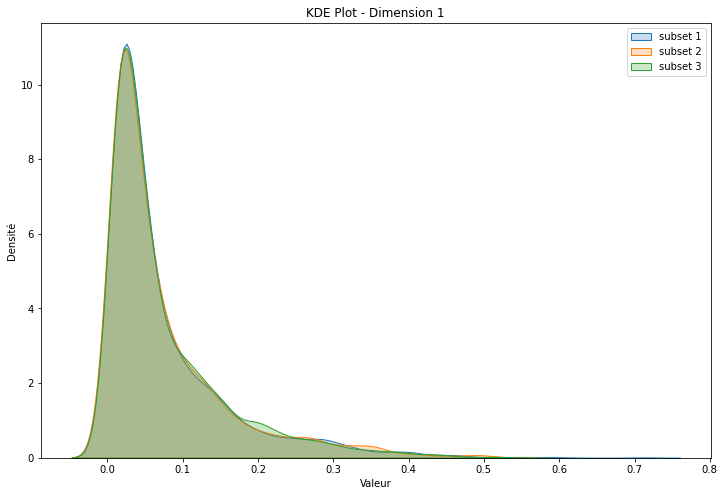

In [11]:
# Affichage des trois subsets
plot_1d(features=new_features, target=fakes_news["labels"])

In [12]:
# Dataset final pour les fakes news
fakes_news["author"] = fakes_news["author"].apply(str.lower).apply(format_author)
fakes_news["date"] = fakes_news["date"].apply(str.lower).apply(format_date)
fakes_news["features"] = fakes_news["date"] + ' ' + fakes_news["author"] + ' ' + fakes_news["features"]
fakes_news = fakes_news[["features", "labels"]]
display(fakes_news.head())

,features,labels
0,k2000-10-01k katlanta sports councilk economic...,1
1,k2007-07-25k kjohn mccaink spent dollar xnumx ...,1
2,k2007-09-17k kchain emailk clinton charge secr...,2
3,k2007-09-21k kjohn edwardsk rural school enrol...,2
4,k2007-09-26k kjoe bidenk xnumx xnumx baby born...,1


# Reals news

In [13]:
# Dataset final pour les reals news
reals_news = pd.read_csv("vraie.csv").sort_values(by=["date", "author"]).reset_index(drop=True)
reals_news["features"] = reals_news["text"].apply(preprocess_text).apply(lemmatize_text)
reals_news = reals_news[["date", "author", "features"]]
reals_news = reals_news.drop_duplicates(subset="features", keep="first").reset_index(drop=True)
reals_news["labels"] = 3
reals_news["author"] = reals_news["author"].apply(str.lower).apply(format_author)
reals_news["date"] = reals_news["date"].apply(str.lower).apply(format_date)
reals_news["features"] = reals_news["date"] + ' ' + reals_news["author"] + ' ' + reals_news["features"]
reals_news = reals_news[["features", "labels"]]
display(reals_news.head())

,features,labels
0,k2007-04-26k kmitt romneyk senator mccain vote...,3
1,k2007-05-31k krudy giulianik fifty six percent...,3
2,k2007-07-19k kobama girlk least obama marry co...,3
3,k2007-08-04k kjohn mccaink spent approximately...,3
4,k2007-08-05k kduncan hunterk schip socialized ...,3


# Final dataset

In [14]:
# Enregistrement du dataset final
pd.concat(objs=[fakes_news, reals_news], axis=0).sort_values(by=["labels", "features"]).reset_index(drop=True).to_csv(path_or_buf="fakesNews_dataset.csv", index=False)